# Loading and Analysing Pre-Trained Sparse Autoencoders

## Imports & Installs

## Set Up

In [66]:
import os
import pandas as pd
import numpy as np
import shutil
import json

from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search
from causallearn.utils.cit import kci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.cit import fisherz

In [67]:
#T2P
answer_valuebench_features_csv_gemma_train = os.path.join('useful_data',"ans_gemma_train_formal.csv")
answer_valuebench_features_csv_gemma_test = os.path.join('useful_data',"ans_gemma_test_formal.csv")
answer_valuebench_features_csv_llama_train = os.path.join('useful_data',"ans_llama_train_formal.csv")
answer_valuebench_features_csv_llama_test = os.path.join('useful_data',"ans_llama_test_formal.csv")
# answer_valuebench_features_csv_gemma_train = os.path.join('useful_data',"ans_cross_part1.csv")
# answer_valuebench_features_csv_gemma_test = os.path.join('useful_data',"ans_cross_part2.csv")
# answer_valuebench_features_csv_llama_train = os.path.join('useful_data',"ans_llama_old_train.csv")
# answer_valuebench_features_csv_llama_test = os.path.join('useful_data',"ans_llama_old_test.csv")

data_csv_gemma_train = pd.read_csv(answer_valuebench_features_csv_gemma_train)
data_csv_gemma_test = pd.read_csv(answer_valuebench_features_csv_gemma_test)
data_csv_llama_train = pd.read_csv(answer_valuebench_features_csv_llama_train)
data_csv_llama_test = pd.read_csv(answer_valuebench_features_csv_llama_test)

#T2P
exclude_columns_gemma = ['Social','Breath of Interest','Economic','Religion','Social Cynicism','Theoretical','Understanding']
exclude_rows_gemma = [11712, 1025, 1341, 2221, 2965, 3402, 6188, 6884, 7502, 10454, 12703, 14185, 14351]
exclude_columns_llama = []
exclude_rows_llama = [60312, 7754, 13033, 1897, 2509, 20141, 41929, 48321, 63905, 49202, 2246, 58305]
# data_csv_gemma_train = data_csv_gemma_train[~data_csv_gemma_train['steer_dim'].isin(exclude_rows_gemma)]
# data_csv_gemma_test = data_csv_gemma_test[~data_csv_gemma_test['steer_dim'].isin(exclude_rows_gemma)]
data_csv_llama_train = data_csv_llama_train[~data_csv_llama_train['steer_dim'].isin(exclude_rows_llama)]
data_csv_llama_test = data_csv_llama_test[~data_csv_llama_test['steer_dim'].isin(exclude_rows_llama)]


In [68]:
def get_data_new_diff(data_csv_raw, modelname, threshold_judge):
    assert threshold_judge >= 0
    pathname = 'value_dims_rsd_' + modelname
    stat_csv_23 = pathname + '/23_stat.csv'
    data_new_diff_count_total = pd.DataFrame()

    if os.path.exists('pathname'):
        shutil.rmtree('pathname')
    os.makedirs(pathname, exist_ok=True)
    
    for column in data_csv_raw.columns:
        if column == 'player_name' or column == 'steer_dim' or column == 'stds' or column =='scstds' or column.endswith(':scstd'):
            continue
        value_csv = pathname + '/' + column + '.csv'
        data_new = data_csv_raw.pivot(index='steer_dim', columns='player_name', values=column)
        data_new_scstd = data_csv_raw.pivot(index='steer_dim', columns='player_name', values=column+':scstd')
        data_save = data_new.astype(str) + '±' + data_new_scstd.astype(str) #problems here: the scstd is not the std for the score, but fore the changed score
        data_save.to_csv(value_csv)

        data_new_diff = data_new - data_new[data_new.index.isnull()].iloc[0]

        data_new_diff_count_higher = data_new_diff.apply(lambda x: x.apply(lambda y: 1 if y > threshold_judge else 0))
        data_new_diff_count_higher = data_new_diff_count_higher.sum(axis=1)
        data_new_diff_count_lower = data_new_diff.apply(lambda x: x.apply(lambda y: 1 if y < -threshold_judge else 0))
        data_new_diff_count_lower = data_new_diff_count_lower.sum(axis=1)
        data_new_diff_count_equal = data_new_diff.apply(lambda x: x.apply(lambda y: 1 if abs(y) <= threshold_judge else 0))
        data_new_diff_count_equal = data_new_diff_count_equal.sum(axis=1)

        data_new_diff_count = data_new_diff_count_higher.astype(str) + '/' + data_new_diff_count_lower.astype(str) + '/' + data_new_diff_count_equal.astype(str)
        data_new_diff_count_total[column] = data_new_diff_count

    data_new_diff_count_total.to_csv(stat_csv_23)

get_data_new_diff(data_csv_gemma_train, 'gemma', threshold_judge=0)
get_data_new_diff(data_csv_gemma_test, 'gemmatest', threshold_judge=0)
get_data_new_diff(data_csv_llama_train, 'llama', threshold_judge=0)
get_data_new_diff(data_csv_llama_test, 'llamatest', threshold_judge=0)

In [69]:
def get_table1_newest(stat_csv_23_train, stat_csv_23_test):
    data_new_diff_count_total_train = pd.read_csv(stat_csv_23_train)
    data_new_diff_count_total_test = pd.read_csv(stat_csv_23_test)

    table1_rows = data_new_diff_count_total_train['steer_dim'].unique()
    table1_rows = table1_rows[~np.isnan(table1_rows)]
    table1_columns = data_new_diff_count_total_train.columns[data_new_diff_count_total_train.columns != 'steer_dim']

    table1_rows_test = data_new_diff_count_total_test['steer_dim'].unique()
    table1_rows_test = table1_rows_test[~np.isnan(table1_rows_test)]
    table1_columns_test = data_new_diff_count_total_test.columns[data_new_diff_count_total_test.columns != 'steer_dim']

    assert np.array_equal(table1_rows, table1_rows_test)
    assert np.array_equal(table1_columns, table1_columns_test)
    
    table1 = pd.DataFrame(columns=table1_columns, index=table1_rows)
    
    for steer_dim in table1_rows:
        assert not np.isnan(steer_dim)

        steer_dim_row_train = data_new_diff_count_total_train[data_new_diff_count_total_train['steer_dim'] == steer_dim]
        steer_dim_row_test = data_new_diff_count_total_test[data_new_diff_count_total_test['steer_dim'] == steer_dim]

        for column in table1_columns:
            assert column != 'steer_dim'
            #split cell by /
            counts_train = steer_dim_row_train[column].values[0].split('/')   
            simu_train = int(counts_train[0])
            supp_train = int(counts_train[1])
            main_train = int(counts_train[2])
            
            counts_test = steer_dim_row_test[column].values[0].split('/')
            simu_test = int(counts_test[0])
            supp_test = int(counts_test[1])
            main_test = int(counts_test[2])

            table1.loc[steer_dim, column] = str(simu_train) + '/' + str(supp_train) + '/' + str(main_train) + '/' + str(simu_test) + '/' + str(supp_test) + '/' + str(main_test)
    return table1

table1_gemma = get_table1_newest('value_dims_rsd_gemma/23_stat.csv', 'value_dims_rsd_gemmatest/23_stat.csv')
table1_gemma.to_csv('table1_gemma_newest.csv')
table1_llama = get_table1_newest('value_dims_rsd_llama/23_stat.csv', 'value_dims_rsd_llamatest/23_stat.csv')
table1_llama.to_csv('table1_llama_newest.csv')

In [70]:
def get_latex_table1_rotate_tutu(table1, table1_name, modelname, exclude_rows=None, exclude_columns=None):
    if exclude_rows is None:
        exclude_rows = []
    if exclude_columns is None:
        exclude_columns = []

    #value_dims = [str(vd) for vd in table1.index if vd not in exclude_rows]
    value_dims = [str(vd) for vd in table1.columns if vd not in exclude_columns]
    #steering_features = [int(sf) for sf in table1.columns if sf not in exclude_columns]
    steering_features = [int(sf) for sf in table1.index if sf not in exclude_rows]

    table_filtered = table1.loc[steering_features, value_dims]

    # 初始化 LaTeX 代码
    latex_code = '''
\\newcommand{\\cellbar}[5]{%
    \\raisebox{\\height}{%
        \\begin{tikzpicture}[baseline=(current bounding box.center)]
            \\draw[draw=black] (0,0) rectangle (1cm,0.4cm);
            \\path[fill=CustomBlue, opacity=#5] (0,0) rectangle (#1cm,0.4cm);
            \\path[fill=white] (#1cm,0) rectangle ({#1cm + #3cm},0.4cm);
            \\path[fill=CustomYellow, opacity=#5] ({#1cm + #3cm},0) rectangle (1cm,0.4cm);
            \\node[anchor=center, font=\\scriptsize] at (0.5cm,0.2cm) {#2};
        \\end{tikzpicture}%
    }%
}
\\begin{table*}[ht]
\\centering
\\caption{Value steering using SAE features for the {''' + modelname + '''} model. For each pair of steering feature and value dimension, the cell shows the stimulation ratio in blue, the suppression ratio in yellow, and the maintenance ratio in blank, which are estimated from the training data. The numbers in the cell represent the distance between the actual ratios in the testing data and expected ratios.}\n
\\label{table: sae-steering-''' + modelname + '''}
\\resizebox{\\textwidth}{!}{%
\\begin{tabular}{>{\\centering\\arraybackslash}m{1.5cm} *{''' + str(len(value_dims)) + '''}{>{\\centering\\arraybackslash}m{1cm}}>{\\centering\\arraybackslash}m{1cm}}
\\toprule
'''

    # 生成表头
    header_row = ['\\rotatebox{90}{\\textbf{Value}}'] + ['\\rotatebox{90}{\\textbf{' + vd + '}}' for vd in value_dims] + ['\\textbf{AVG}']
    latex_code += ' & '.join(header_row) + ' \\\\\n\\midrule\n'

    # 定义单元格内容的生成函数
    def generate_cell_content(red_ratio, green_ratio, transparency_ratio, similarity):
        """
        生成单元格的 LaTeX 代码，使用 \\cellbar{red_length}{similarity}{transparency_length}{green_length}{opacity}
        """
        # 确保比例在 0 到 1 之间，并归一化
        total = red_ratio + green_ratio + transparency_ratio
        if total > 0:
            red_ratio /= total
            green_ratio /= total
            transparency_ratio /= total
        else:
            red_ratio = green_ratio = transparency_ratio = 0.0

        red_length = red_ratio
        transparency_length = transparency_ratio
        green_length = green_ratio

        opacity = 1.0 - transparency_ratio  # 透明度与透明部分成反比

        return f'\\cellbar{{{red_length:.2f}}}{{{similarity:.2f}}}{{{transparency_length:.2f}}}{{{green_length:.2f}}}{{{opacity:.2f}}}'

    # 生成表格内容
    for sf in steering_features:
        cosines = []
        row = ['\\textbf{' + str(sf) + '}']
        for vd in value_dims:
            value = table_filtered.loc[sf, vd]
            if isinstance(value, str):
                # 处理字符串值，计算相似度
                value_list = list(map(int, value.split('/')))
                traindata = value_list[:3]
                testdata = value_list[3:]
                # 计算相似度
                traindata_p = np.array(traindata) / np.sum(traindata)
                testdata_p = np.array(testdata) / np.sum(testdata)
                similarity = np.dot(traindata_p, testdata_p) / (np.linalg.norm(traindata_p) * np.linalg.norm(testdata_p))
                cosines.append(similarity)

                # 提取红色、绿色和透明度的值
                red_value = traindata[0]
                green_value = traindata[1]
                transparency_value = traindata[2]
                # 计算比例
                red_ratio = red_value
                green_ratio = green_value
                transparency_ratio = transparency_value

                # 生成单元格内容
                cell_content = generate_cell_content(red_ratio, green_ratio, transparency_ratio, similarity)
                row.append(cell_content)
            else:
                row.append('')

        avg_similarity = np.mean(cosines) if cosines else 0
        row.append(f'{avg_similarity:.2f}')
        latex_code += ' & '.join(row) + ' \\\\\n'
    latex_code += '\\bottomrule\n\\end{tabular}\n}\n\\end{table*}\n'

    # 保存 LaTeX 代码
    with open(f'{table1_name}.tex', 'w') as f:
        f.write(latex_code)
  

get_latex_table1_rotate_tutu(table1_gemma, 'table1_gemma_rotate', 'Gemma-2B-IT', exclude_rows_gemma, exclude_columns_gemma)
get_latex_table1_rotate_tutu(table1_llama, 'table1_llama_rotate', 'Llama3-8B-IT', exclude_rows_llama, exclude_columns_llama)


In [71]:
#T2P
CAUSAL_METHOD = 'pc'
NOISE_AUGUMENT_SINGLE_SAE = None #10
NOISE_VAR = 0.00001
PC_ALPHA = 0.05 #0.0005


In [72]:
def get_valid_d_columns_deprecated(answer_valuebench_features_csv):
    data_csv = pd.read_csv(answer_valuebench_features_csv)
    digits = [str(d) for d in range(10)]
    d_columns = [d for d in data_csv.columns if d[0] in digits]
    d_data = data_csv[d_columns]
    stds = d_data.std()
    avgs = d_data.mean()
    std_avg = stds/avgs
    #d_columns_valid = [d for d in d_columns if avgs[d] > 1]
    d_columns_valid = d_columns
    return d_columns_valid

def get_value_dims_from_csv(data_csv):
    return [v for v in data_csv.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]

def causal_inference(data, ci_dimensions, pdy_name, method, noise_augument=None, prior_source_set=None):
    if noise_augument:
        data = np.tile(data, (noise_augument, 1))
        noise = np.random.normal(0, NOISE_VAR, data.shape)
        data = data + noise

    if method == 'pc':
        g = pc(data, PC_ALPHA, node_names=ci_dimensions)
        
        if prior_source_set:
            bk = BackgroundKnowledge()
            nodes = g.G.get_nodes()
            for node1 in nodes:
                for node2 in nodes:
                    if node1.name in prior_source_set and node2.name in prior_source_set and node1.name != node2.name:
                        bk = bk.add_forbidden_by_node(node1, node2)
            g = pc(data, PC_ALPHA, node_names=ci_dimensions, background_knowledge=bk)
            
        graph = g.G

        edges = []
        for n1 in range(len(graph.nodes)):
            assert graph.nodes[n1].name == ci_dimensions[n1]
            for n2 in range(n1+1, len(graph.nodes)):
                # if n1 == n2:
                #     continue
                if graph.graph[n1][n2] == -1 and graph.graph[n2][n1] == 1:
                    edges.append([graph.nodes[n1].name, graph.nodes[n2].name, 1, 'single-arrow'])
                elif graph.graph[n1][n2] == 1 and graph.graph[n2][n1] == -1:
                    edges.append([graph.nodes[n2].name, graph.nodes[n1].name, 1, 'single-arrow']) 
                elif graph.graph[n1][n2] == -1 and graph.graph[n2][n1] == -1:
                    edges.append([graph.nodes[n1].name, graph.nodes[n2].name, 1, 'no-arrow'])
                elif graph.graph[n1][n2] == 1 and graph.graph[n2][n1] == 1:
                    edges.append([graph.nodes[n1].name, graph.nodes[n2].name, 1, 'double-arrow'])
                else:
                    if not (graph.graph[n1][n2] == 0 and graph.graph[n2][n1] == 0):
                        raise ValueError('Invalid edge')
    else:
        raise ValueError('Invalid method')
    
    columns_concerned_vis = [label.replace(':','-') for label in ci_dimensions]
    pdy = GraphUtils.to_pydot(graph, labels=columns_concerned_vis)
    pdy.write_png(pdy_name)
    return edges


def deal_with_csv(data_csv, graph_path, v_showongraph='ALL', row_num='ALL', method=CAUSAL_METHOD, dummy_steered_dim=False): 
    v_inference = get_value_dims_from_csv(data_csv)
    if os.path.exists(graph_path):
        shutil.rmtree(graph_path)
    os.makedirs(graph_path, exist_ok=True)
    
    # data_csv = pd.read_csv(answer_valuebench_features_csv)
    # v_columns_all = [v for v in data_csv.columns if (v not in ['player_name', 'steer_dim', 'stds']) and (not v.endswith(':scstd'))]
    # if v_inference == 'ALL':
    #     v_columns_inference = v_columns_all
    # else:
    #     for v in v_inference:
    #         if v not in v_columns_all:
    #             raise ValueError('Invalid v_inference')
    #     v_columns_inference = v_inference

    v_columns_inference = v_inference

    if v_showongraph == 'ALL':
        v_columns_showgraph = v_columns_inference
    else:
        for v in v_showongraph:
            if v not in v_columns_inference:
                raise ValueError('Invalid v_showongraph')
        v_columns_showgraph = v_showongraph

    if dummy_steered_dim:
        steer_dim_dummies = pd.get_dummies(data_csv['steer_dim'], prefix='steer_dim') * 1
        data = pd.concat([data_csv, steer_dim_dummies], axis=1)
        v_columns_inference_total = v_columns_inference + list(steer_dim_dummies.columns) 
        v_columns_showgraph_total = v_columns_showgraph + list(steer_dim_dummies.columns)
    else:
        data = data_csv
        v_columns_inference_total = v_columns_inference
        v_columns_showgraph_total = v_columns_showgraph
    
    data = data[v_columns_inference_total].to_numpy()    
    
    if type(row_num) == int:
        rows = np.random.choice(data.shape[0], row_num, replace=False)
        data = data[rows]
    else:
        assert row_num == 'ALL'

    if dummy_steered_dim:
        edges_total = causal_inference(data, v_columns_inference_total, graph_path + "/total.png", method, noise_augument=None, prior_source_set=list(steer_dim_dummies.columns))
    else:
        edges_total = causal_inference(data, v_columns_inference_total, graph_path + "/total.png", method, noise_augument=None)
    
    edges_sfs = []
    steer_dims = data_csv['steer_dim'].unique()
    for steer_dim in steer_dims:
        print(steer_dim)
        if np.isnan(steer_dim):
            data = data_csv[data_csv['steer_dim'].isnull()][v_columns_inference].to_numpy()
            edges_nosteer = causal_inference(data, v_columns_inference, graph_path + f'/{steer_dim}.png', method, noise_augument=NOISE_AUGUMENT_SINGLE_SAE)
        else:
            data = data_csv[data_csv['steer_dim'] == steer_dim][v_columns_inference].to_numpy()
            sfedge = causal_inference(data, v_columns_inference, graph_path + f'/{steer_dim}.png', method, noise_augument=NOISE_AUGUMENT_SINGLE_SAE)
            edges_sfs.append(sfedge)

    return edges_total, edges_nosteer, edges_sfs

#T2P
edges_gemma_total, edges_gemma_nosteer, edges_gemma_sfs = deal_with_csv(data_csv_gemma_train, 'value_causal_graph_gemma')
edges_llama_total, edges_llama_nosteer, edges_llama_sfs = deal_with_csv(data_csv_llama_train, 'value_causal_graph_llama')

  0%|          | 0/17 [00:00<?, ?it/s]

nan


  0%|          | 0/17 [00:00<?, ?it/s]

10096.0


  0%|          | 0/17 [00:00<?, ?it/s]

8387.0


  0%|          | 0/17 [00:00<?, ?it/s]

2221.0


  0%|          | 0/17 [00:00<?, ?it/s]

1312.0


  0%|          | 0/17 [00:00<?, ?it/s]

7502.0


  0%|          | 0/17 [00:00<?, ?it/s]

14049.0


  0%|          | 0/17 [00:00<?, ?it/s]

3183.0


  0%|          | 0/17 [00:00<?, ?it/s]

6619.0


  0%|          | 0/17 [00:00<?, ?it/s]

1341.0


  0%|          | 0/17 [00:00<?, ?it/s]

6884.0


  0%|          | 0/17 [00:00<?, ?it/s]

12703.0


  0%|          | 0/17 [00:00<?, ?it/s]

11712.0


  0%|          | 0/17 [00:00<?, ?it/s]

14185.0


  0%|          | 0/17 [00:00<?, ?it/s]

10454.0


  0%|          | 0/17 [00:00<?, ?it/s]

6216.0


  0%|          | 0/17 [00:00<?, ?it/s]

1975.0


  0%|          | 0/17 [00:00<?, ?it/s]

10605.0


  0%|          | 0/17 [00:00<?, ?it/s]

6188.0


  0%|          | 0/17 [00:00<?, ?it/s]

4752.0


  0%|          | 0/17 [00:00<?, ?it/s]

3402.0


  0%|          | 0/17 [00:00<?, ?it/s]

1025.0


  0%|          | 0/17 [00:00<?, ?it/s]

428.0


  0%|          | 0/17 [00:00<?, ?it/s]

14351.0


  0%|          | 0/17 [00:00<?, ?it/s]

2965.0


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

nan


  0%|          | 0/17 [00:00<?, ?it/s]

12477.0


  0%|          | 0/17 [00:00<?, ?it/s]

54606.0


  0%|          | 0/17 [00:00<?, ?it/s]

21347.0


  0%|          | 0/17 [00:00<?, ?it/s]

4305.0


  0%|          | 0/17 [00:00<?, ?it/s]

30919.0


  0%|          | 0/17 [00:00<?, ?it/s]

34598.0


  0%|          | 0/17 [00:00<?, ?it/s]

51010.0


  0%|          | 0/17 [00:00<?, ?it/s]

62769.0


  0%|          | 0/17 [00:00<?, ?it/s]

47207.0


  0%|          | 0/17 [00:00<?, ?it/s]

8035.0


  0%|          | 0/17 [00:00<?, ?it/s]

8546.0


  0%|          | 0/17 [00:00<?, ?it/s]

9332.0


  0%|          | 0/17 [00:00<?, ?it/s]

In [73]:
# edges_standard_json = json.load(open('value_graph_smallset_triplets.json'))
# edges_standard = []
# for edge in edges_standard_json:
#     if edge[1] == '-->':
#         edges_standard.append([edge[0], edge[2], 1, 'single-arrow'])
#     elif edge[1] == 'o--o':
#         edges_standard.append([edge[0], edge[2], 1, 'double-arrow'])
#     else:
#         raise ValueError('Invalid edge')

edges_standard = [
    ['Positive coping', 'Resilience', 1, 'single-arrow'],
    ['Resilience', 'Achievement', 1, 'single-arrow'],
    ['Empathy', 'Social Complexity', 1, 'single-arrow'],
    ['Social Complexity', 'Social', 1, 'double-arrow'],
    ['Uncertainty Avoidance', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Aesthetic', 'Breadth of Interest', 1, 'single-arrow'],
    ['Breadth of Interest', 'Resilience', 1, 'single-arrow'],
    ['Organization', 'Economic', 1, 'single-arrow'],
    ['Political', 'Social Cynicism', 1, 'single-arrow'],
    ['Religious', 'Understanding', 1, 'single-arrow'],
    ['Theoretical', 'Understanding', 1, 'single-arrow'],
    ['Understanding', 'Empathy', 1, 'double-arrow'],
    ['Empathy', 'Achievement', 1, 'single-arrow'],
    ['Resilience', 'Social Complexity', 1, 'single-arrow'],
    ['Positive coping', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Economic', 'Achievement', 1, 'single-arrow'],
    ['Political', 'Economic', 1, 'double-arrow'],
    ['Social Cynicism', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Understanding', 'Positive coping', 1, 'double-arrow'],
    ['Organization', 'Social', 1, 'single-arrow'],
]

edges_standard_small = [
    ['Positive coping', 'Resilience', 1, 'single-arrow'],
    ['Empathy', 'Social', 1, 'single-arrow'],
    ['Empathy', 'Resilience', 1, 'single-arrow'],
    ['Resilience', 'Achievement', 1, 'single-arrow'],
    ['Social Complexity', 'Breadth of Interest', 1, 'single-arrow'],
    ['Uncertainty Avoidance', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Anxiety Disorder', 'Social Cynicism', 1, 'single-arrow'],
    ['Economic', 'Organization', 1, 'single-arrow'],
    ['Political', 'Social Cynicism', 1, 'single-arrow'],
    ['Religious', 'Understanding', 1, 'single-arrow'],
]

edges_valuebench = []

edges_random = [
    ['Positive coping', 'Economic', 1, 'double-arrow'],
    ['Empathy', 'Achievement', 1, 'single-arrow'],
    ['Resilience', 'Social Cynicism', 1, 'double-arrow'],
    ['Social Complexity', 'Breadth of Interest', 1, 'single-arrow'],
    ['Achievement', 'Uncertainty Avoidance', 1, 'double-arrow'],
    ['Uncertainty Avoidance', 'Anxiety Disorder', 1, 'single-arrow'],
    ['Aesthetic', 'Religious', 1, 'double-arrow'],
    ['Anxiety Disorder', 'Understanding', 1, 'single-arrow'],
    ['Breadth of Interest', 'Theoretical', 1, 'double-arrow'],
    ['Economic', 'Political', 1, 'single-arrow'],
    ['Organization', 'Social', 1, 'double-arrow'],
    ['Political', 'Aesthetic', 1, 'single-arrow'],
    ['Religious', 'Empathy', 1, 'double-arrow'],
    ['Theoretical', 'Positive coping', 1, 'single-arrow'],
    ['Understanding', 'Social Complexity', 1, 'double-arrow'],
    ['Social', 'Resilience', 1, 'single-arrow'],
    ['Social Cynicism', 'Breadth of Interest', 1, 'double-arrow'],
    ['Positive coping', 'Aesthetic', 1, 'single-arrow'],
    ['Empathy', 'Theoretical', 1, 'double-arrow'],
    ['Resilience', 'Organization', 1, 'single-arrow'],
]


# edges_standard_old = [
#     ['Emotional Processing', 'Emotional Expression', 1, 'single-arrow'],
#     ['Emotional Processing', 'Psychosocial Flourishing', 1, 'single-arrow'],
#     ['Perspective Taking', 'Sympathy', 1, 'single-arrow'],
#     ['Perspective Taking', 'Empathy', 1, 'double-arrow'],
#     ['Perspective Taking', 'Nurturance', 1, 'double-arrow'],
#     ['Sociability', 'Extraversion', 1, 'double-arrow'],
#     ['Sociability', 'Warmth', 1, 'double-arrow'],
#     ['Sociability', 'Positive Expressivity', 1, 'double-arrow'],
#     ['Dependence', 'Nurturance', 1, 'single-arrow'],
#     ['Psychosocial Flourishing', 'Satisfaction with life', 1, 'single-arrow'],
#     ['Psychosocial Flourishing', 'Nurturance', 1, 'single-arrow'],
#     ['Extraversion', 'Positive Expressivity', 1, 'single-arrow'],
#     ['Extraversion', 'Social Confidence', 1, 'single-arrow'],
#     ['Extraversion', 'Social', 1, 'double-arrow'],
#     ['Affiliation', 'Empathy', 1, 'double-arrow'],
#     ['Affiliation', 'Social', 1, 'double-arrow'],
#     ['Understanding', 'Empathy', 1, 'double-arrow'],
#     ['Understanding', 'Reflection', 1, 'double-arrow'],
#     ['Understanding', 'Depth', 1, 'single-arrow'],
#     ['Understanding', 'Theoretical', 1, 'double-arrow'],
#     ['Sympathy', 'Nurturance', 1, 'single-arrow'],
#     ['Warmth', 'Empathy', 1, 'single-arrow'], 
#     ['Warmth', 'Nurturance', 1, 'double-arrow'],
#     ['Warmth', 'Positive Expressivity', 1, 'single-arrow'],
#     ['Warmth', 'Social', 1, 'single-arrow'], 
#     ['Empathy', 'Tenderness', 1, 'double-arrow'],
#     ['Empathy', 'Nurturance', 1, 'double-arrow'], 
#     ['Positive Expressivity', 'Social', 1, 'double-arrow'],
# ]

In [74]:
def check_zero_double_arrow(edges):
    double_arrow_edges = [edge for edge in edges if edge[3] == 'double-arrow']
    zero_arrow_edges = [edge for edge in edges if edge[3] == 'no-arrow']
    if double_arrow_edges:
        raise ValueError('Double arrow:', double_arrow_edges)
    if zero_arrow_edges:
        raise ValueError('Zero arrow:', zero_arrow_edges)

def dealwith_zero_double_duplicated_arrow(edges):
    double_arrow_edges = [edge for edge in edges if edge[3] == 'double-arrow']
    zero_arrow_edges = [edge for edge in edges if edge[3] == 'no-arrow']
    print('Double arrow:', double_arrow_edges)
    print('Zero arrow:', zero_arrow_edges)
    print('Dealwith zero and double arrow edges')
    print('----------------------')
    
    new_edges = []
    for edge in edges:
        if edge[3] == 'double-arrow' or edge[3] == 'no-arrow':
            if [edge[0], edge[1], edge[2], 'single-arrow'] not in new_edges:
                new_edges.append([edge[0], edge[1], edge[2], 'single-arrow'])
            if [edge[1], edge[0], edge[2], 'single-arrow'] not in new_edges:
                new_edges.append([edge[1], edge[0], edge[2], 'single-arrow'])
        else:
            if edge not in new_edges:
                new_edges.append(edge)
    return new_edges

def check_dag(edges):
    nxg = nx.DiGraph()
    for edge in edges:
        if edge[3] == 'single-arrow':
            nxg.add_edge(edge[0], edge[1])
    if not nx.is_directed_acyclic_graph(nxg):
        cycles = list(nx.simple_cycles(nxg))
        raise ValueError('Cycle:', cycles)

#T2P
edges_gemma_total = dealwith_zero_double_duplicated_arrow(edges_gemma_total)
edges_gemma_nosteer = dealwith_zero_double_duplicated_arrow(edges_gemma_nosteer)
edges_gemma_sfs = [dealwith_zero_double_duplicated_arrow(edges_sf) for edges_sf in edges_gemma_sfs]
edges_llama_total = dealwith_zero_double_duplicated_arrow(edges_llama_total)
edges_llama_nosteer = dealwith_zero_double_duplicated_arrow(edges_llama_nosteer)
edges_llama_sfs = [dealwith_zero_double_duplicated_arrow(edges_sf) for edges_sf in edges_llama_sfs]
edges_standard = dealwith_zero_double_duplicated_arrow(edges_standard)
edges_standard_small = dealwith_zero_double_duplicated_arrow(edges_standard_small)
edges_random = dealwith_zero_double_duplicated_arrow(edges_random)





Double arrow: []
Zero arrow: [['Positive coping', 'Religious', 1, 'no-arrow'], ['Theoretical', 'Uncertainty Avoidance', 1, 'no-arrow']]
Dealwith zero and double arrow edges
----------------------
Double arrow: []
Zero arrow: [['Achievement', 'Religious', 1, 'no-arrow'], ['Anxiety Disorder', 'Social Cynicism', 1, 'no-arrow'], ['Economic', 'Uncertainty Avoidance', 1, 'no-arrow'], ['Empathy', 'Organization', 1, 'no-arrow'], ['Resilience', 'Social', 1, 'no-arrow']]
Dealwith zero and double arrow edges
----------------------
Double arrow: []
Zero arrow: [['Economic', 'Organization', 1, 'no-arrow'], ['Religious', 'Uncertainty Avoidance', 1, 'no-arrow']]
Dealwith zero and double arrow edges
----------------------
Double arrow: []
Zero arrow: [['Breadth of Interest', 'Empathy', 1, 'no-arrow'], ['Organization', 'Uncertainty Avoidance', 1, 'no-arrow'], ['Positive coping', 'Religious', 1, 'no-arrow'], ['Social Complexity', 'Theoretical', 1, 'no-arrow']]
Dealwith zero and double arrow edges
------

In [75]:
def get_all_subsequent_nodes(edges, node):
    #T2P
    check_zero_double_arrow(edges)

    subsequent_nodes = set()
    subsequent_nodes.add(node)
    while True:
        subsequent_nodes_len = len(subsequent_nodes)
        for edge in edges:
            if edge[0] in subsequent_nodes:
                subsequent_nodes.add(edge[1])
        if len(subsequent_nodes) == subsequent_nodes_len:
            break
    subsequent_nodes.remove(node)
    return subsequent_nodes

def get_all_preceding_nodes(edges, node):
    #T2P
    check_zero_double_arrow(edges)

    preceding_nodes = set()
    preceding_nodes.add(node)
    while True:
        preceding_nodes_len = len(preceding_nodes)
        for edge in edges:
            if edge[1] in preceding_nodes:
                preceding_nodes.add(edge[0])
        if len(preceding_nodes) == preceding_nodes_len:
            break
    preceding_nodes.remove(node)
    return preceding_nodes

def get_all_un_related_nodes(edges, node, all_nodes):
    #T2P
    check_zero_double_arrow(edges)
   

    #find all nodes that are in a same connected component with node
    unrelated_nodes = set(all_nodes)
    connected_nodes = set()
    connected_nodes.add(node) 
    while True:
        connected_nodes_len = len(connected_nodes)
        for edge in edges:
            if edge[0] in connected_nodes:
                connected_nodes.add(edge[1])
            if edge[1] in connected_nodes:
                connected_nodes.add(edge[0])
        if len(connected_nodes) == connected_nodes_len:
            break
    unrelated_nodes = unrelated_nodes - connected_nodes

    #T2P
    #return unrelated_nodes, connected_nodes - set([node])
    return set(all_nodes) - get_all_subsequent_nodes(edges, node) - set([node]) - get_all_preceding_nodes(edges, node), connected_nodes - set([node])

def get_all_non_subsequent_nodes(edges, node, all_nodes):
    #T2P
    check_zero_double_arrow(edges)
    return set(all_nodes) - get_all_subsequent_nodes(edges, node) - set([node])



print(get_all_subsequent_nodes(edges_standard_small, 'Understanding'))
print(get_all_preceding_nodes(edges_standard_small, 'Understanding'))
v_inference = [v for v in data_csv_gemma_train.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
print(get_all_un_related_nodes(edges_standard_small, 'Understanding', v_inference))

print(get_all_subsequent_nodes(edges_gemma_nosteer, 'Achievement'))
print(get_all_preceding_nodes(edges_gemma_nosteer, 'Achievement'))
v_inference = [v for v in data_csv_gemma_train.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
print(get_all_un_related_nodes(edges_gemma_nosteer, 'Achievement', v_inference))


set()
{'Religious'}
({'Anxiety Disorder', 'Positive coping', 'Aesthetic', 'Social Cynicism', 'Economic', 'Achievement', 'Resilience', 'Political', 'Empathy', 'Theoretical', 'Organization', 'Social Complexity', 'Uncertainty Avoidance', 'Breadth of Interest', 'Social'}, {'Religious'})
{'Religious', 'Positive coping'}
{'Religious'}
({'Empathy', 'Anxiety Disorder', 'Theoretical', 'Understanding', 'Organization', 'Aesthetic', 'Social Cynicism', 'Social Complexity', 'Economic', 'Uncertainty Avoidance', 'Breadth of Interest', 'Resilience', 'Political', 'Social'}, {'Positive coping', 'Political', 'Religious'})


In [81]:
def write_table2(data_scorechange, edges, edges_source, pd_result_table2, stat_method, expected, unexpected):
    for column in data_scorechange.columns:
        print('=============')
        print(column)
                
        subsequent_columns_ideal = get_all_subsequent_nodes(edges, column)
        unrelated_columns_ideal, related_columns_ideal = get_all_un_related_nodes(edges, column, set(data_scorechange.columns))
        non_subsequent_columns_ideal = get_all_non_subsequent_nodes(edges, column, set(data_scorechange.columns))

        if expected == 'subsequent':
            expected_columns_ideal = subsequent_columns_ideal
        elif expected == 'related':
            expected_columns_ideal = related_columns_ideal
        else:
            raise ValueError('Invalid expected')
        
        if unexpected == 'unrelated':
            unexpected_columns_ideal = unrelated_columns_ideal
        elif unexpected == 'non_subsequent':
            unexpected_columns_ideal = non_subsequent_columns_ideal
        else:
            raise ValueError('Invalid unexpected')

        if stat_method == 'change_score':
            related_columns_real = data_scorechange[data_scorechange[column] != 0].abs().mean().sort_values()
            #related_columns_real = data_scorechange[data_scorechange[column].abs() > 0.1].abs().mean().sort_values()
            #related_columns_real = data_scorechange.abs().mean().sort_values()
        elif stat_method == 'change_count':
            related_columns_real = data_scorechange[data_scorechange[column] != 0]
            related_columns_real = related_columns_real.astype(bool).mean(axis=0)#.sort_values()
        else:
            raise ValueError('Invalid stat_method')

        def classify(vd):
            if vd in expected_columns_ideal:
                return 'expected'
            elif vd in unexpected_columns_ideal:
                return 'unexpected'
            else:
                return 'none'

        expected_scabs = []
        unexpected_scabs = []
        for related_column in related_columns_real.index:
            if related_column in expected_columns_ideal:
                expected_scabs.append(related_columns_real[related_column])
            elif related_column in unexpected_columns_ideal:
                unexpected_scabs.append(related_columns_real[related_column])
            else:
                pass
                #assert related_column == column
            print(related_column, related_columns_real[related_column], classify(related_column))
        print('~~~')
        
        print('Expected:', np.mean([vdsc for vdsc in expected_scabs if not np.isnan(vdsc)]), len(expected_scabs))
        print('Unexpected:', np.mean([vdsc for vdsc in unexpected_scabs if not np.isnan(vdsc)]), len(unexpected_scabs))
        print('Expected:', np.mean(expected_scabs), len(expected_scabs))
        print('Unexpected:', np.mean(unexpected_scabs), len(unexpected_scabs))

        mean_scorechange_related = 'mean_scorechange_' + edges_source + '_expected'
        num_related = 'num_' + edges_source + '_expected'
        mean_scorechange_unrelated = 'mean_scorechange_' + edges_source + '_unexpected'
        num_unrelated = 'num_' + edges_source + '_unexpected'

        pd_result_table2.loc[mean_scorechange_related, column] = np.mean(expected_scabs)
        #pd_result_table2.loc[num_related, column] = len(expected_scabs)
        pd_result_table2.loc[mean_scorechange_unrelated, column] = np.mean(unexpected_scabs)
        #pd_result_table2.loc[num_unrelated, column] = len(unexpected_scabs)
        print('----------------------')

def create_table2(data_csv, fixed_role, fixed_sf, change_base, modelname, edges_trained, edges_ref, stat_method, expected, unexpected, pd_result_table2):
    assert modelname in ['gemma', 'llama']
    data_source = modelname

    roles = data_csv['player_name'].unique()
    sfs = data_csv['steer_dim'].unique()
    if not fixed_role:
        assert fixed_sf in sfs or fixed_sf == 'plain'
    else:
        assert fixed_role in roles or fixed_role == 'plain'
        assert not fixed_sf
    
    assert change_base in ['zero', 'first']  
    assert stat_method in ['change_score', 'change_count']
    assert expected in ['subsequent', 'related']
    assert unexpected in ['unrelated', 'non_subsequent']

    if fixed_sf:
        if fixed_sf == 'plain':
            data_nosteer = data_csv[data_csv['steer_dim'].isnull()]
        else:
            data_nosteer = data_csv[data_csv['steer_dim'] == fixed_sf]

        if change_base == 'first':
            data_nosteer = data_nosteer[data_csv['player_name'].notnull()]
        else:
            assert np.isnan(data_nosteer.iloc[0]['player_name'])

        data_nosteer = data_nosteer[v_inference + ['player_name']]
        data_nosteer = data_nosteer.set_index('player_name')

    if fixed_role:
        if fixed_role == 'plain':
            data_nosteer = data_csv[data_csv['player_name'].isnull()]
        else:
            data_nosteer = data_csv[data_csv['player_name'] == fixed_role]
        
        if change_base == 'first':
            data_nosteer = data_nosteer[data_csv['steer_dim'].notnull()]
        else:
            assert np.isnan(data_nosteer.iloc[0]['steer_dim'])

        data_nosteer = data_nosteer[v_inference + ['steer_dim']]
        data_nosteer = data_nosteer.set_index('steer_dim')
    
    data_nosteer = data_nosteer.astype(float)

    data_scorechange = data_nosteer - data_nosteer.iloc[0]
    assert v_inference == data_scorechange.columns.tolist()
    
    steer_func = '_prompt' if fixed_sf else '_sae'
    write_table2(data_scorechange, edges_trained, steer_func + '_ours' , pd_result_table2, stat_method, expected, unexpected)
    write_table2(data_scorechange, edges_ref, steer_func + '_refs', pd_result_table2, stat_method, expected, unexpected)


v_inference_gemma = [v for v in data_csv_gemma_test.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
v_inference_llama = [v for v in data_csv_llama_test.columns if (v not in ['player_name', 'steer_dim', 'stds', 'scstds']) and (not v.endswith(':scstd'))]
assert v_inference_gemma == v_inference_llama
v_inference = v_inference_gemma
pd_result_table2_gemma = pd.DataFrame(columns=v_inference)
pd_result_table2_llama = pd.DataFrame(columns=v_inference)

#T2P 
# create_table2(data_csv_gemma_train, fixed_role=None, fixed_sf='plain', change_base="first", modelname='gemma', edges_trained=edges_gemma_nosteer, edges_ref=edges_standard, stat_method='change_score', expected = 'subsequent', unexpected = 'non_subsequent',pd_result_table2=pd_result_table2)
# create_table2(data_csv_llama_train, fixed_role=None, fixed_sf='plain', change_base="first", modelname='llama', edges_trained=edges_llama_nosteer, edges_ref=edges_standard, stat_method='change_score', expected = 'subsequent', unexpected = 'non_subsequent',pd_result_table2=pd_result_table2)

create_table2(data_csv_gemma_test, fixed_role=None, fixed_sf='plain', change_base="first", modelname='gemma', edges_trained=edges_gemma_total, edges_ref=edges_standard_small, stat_method='change_count', expected = 'subsequent', unexpected = 'non_subsequent', pd_result_table2=pd_result_table2_gemma)
create_table2(data_csv_llama_test, fixed_role=None, fixed_sf='plain', change_base="first", modelname='llama', edges_trained=edges_llama_total, edges_ref=edges_standard_small, stat_method='change_count', expected = 'subsequent', unexpected = 'non_subsequent', pd_result_table2=pd_result_table2_llama)

create_table2(data_csv_gemma_test, fixed_role='Erika Jones', fixed_sf=None, change_base="zero", modelname='gemma', edges_trained=edges_gemma_total, edges_ref=edges_standard_small, stat_method='change_count', expected = 'subsequent', unexpected = 'non_subsequent', pd_result_table2=pd_result_table2_gemma)
create_table2(data_csv_llama_test, fixed_role='Erika Jones', fixed_sf=None, change_base="zero", modelname='llama', edges_trained=edges_llama_total, edges_ref=edges_standard_small, stat_method='change_count', expected = 'subsequent', unexpected = 'non_subsequent', pd_result_table2=pd_result_table2_llama)

pd_result_table2_gemma.to_csv('table2_gemma.csv')
pd_result_table2_llama.to_csv('table2_llama.csv')


/tmp/ipykernel_2851310/2699644382.py:95: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_nosteer = data_nosteer[data_csv['player_name'].notnull()]
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  r

Achievement
Achievement 1.0 none
Aesthetic 0.5238095238095238 unexpected
Anxiety Disorder 1.0 unexpected
Breadth of Interest 0.5714285714285714 unexpected
Economic 0.6666666666666666 unexpected
Empathy 0.9523809523809523 unexpected
Organization 0.047619047619047616 unexpected
Political 0.047619047619047616 unexpected
Positive coping 0.7142857142857143 unexpected
Religious 0.9523809523809523 unexpected
Resilience 0.9047619047619048 unexpected
Social 0.9047619047619048 unexpected
Social Complexity 0.5238095238095238 unexpected
Social Cynicism 0.047619047619047616 unexpected
Theoretical 0.047619047619047616 unexpected
Uncertainty Avoidance 0.7619047619047619 unexpected
Understanding 0.8571428571428571 unexpected
~~~
Expected: nan 0
Unexpected: 0.5952380952380952 16
Expected: nan 0
Unexpected: 0.5952380952380952 16
----------------------
Aesthetic
Achievement 0.7857142857142857 unexpected
Aesthetic 1.0 none
Anxiety Disorder 0.9285714285714286 unexpected
Breadth of Interest 0.42857142857142

/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fringsoo/Desktop/all_projs/proj_concordia/SAELens/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of e

In [82]:
#get the amount of questions per value
from sae_lens.config import LOCAL_SAE_MODEL_PATH
#df_valuebench = pd.read_csv(os.path.join(LOCAL_SAE_MODEL_PATH, 'value_data/value_orientation_train.csv'))
df_valuebench = pd.read_csv(os.path.join(LOCAL_SAE_MODEL_PATH, 'value_data/value_orientation_test.csv'))
grouped = df_valuebench.groupby('value')
value_counts = grouped.size().reset_index(name='counts')
#get the value dimensions in v_inference
value_counts = value_counts[value_counts['value'].isin(v_inference)]


In [83]:
def get_latex_table2(group_name):
    index_group = [
        'mean_scorechange__prompt_ours_expected',
        'mean_scorechange__prompt_ours_unexpected',
        'mean_scorechange__prompt_refs_expected',
        'mean_scorechange__prompt_refs_unexpected',
        'mean_scorechange__sae_ours_expected',
        'mean_scorechange__sae_ours_unexpected',
        'mean_scorechange__sae_refs_expected',
        'mean_scorechange__sae_refs_unexpected',
        ]

    #print the table2 in latex
    #rows are for each values dimensions
    #columns are in form num_related_ours(mean_scorechange_related_ours), num_unrelated_ours(mean_scorechange_unrelated_ours), num_related_standard(mean_scorechange_related_standard), num_unrelated_standard(mean_scorechange_unrelated_standard)
    #the values are the number of related values, the mean of the score change of related values, the number of unrelated values, the mean of the score change of unrelated values
    #the values are rounded to 3 decimal places
    #the values are in the form number(mean)
    #the values are in the form of number(mean)
    pd_result_table2 = pd.read_csv('table2_' + group_name + '.csv', index_col=0)
    latex_code = '\\begin{table*}[ht]\n\\caption{The mean of the score change of related values, the number of related values, the mean of the score change of unrelated values, and the number of unrelated values.}\n\\label{table: scorechange}\n\\begin{center}\n'
    #latex_code += '\\begin{tabular}{c@{\\hspace{2pt}}' + 'c@{\\hspace{2pt}}' * (len(pd_result_table2.columns) - 1) + 'c' + '}\n\\toprule\n'
    latex_code += '\\begin{tabular}{c@{\\hspace{2pt}}|' + 'c@{\\hspace{2pt}}' * 4 +'|' + 'c@{\\hspace{2pt}}' * 4 + '}\n\\toprule\n'
    latex_code += 'Value & \\multicolumn{4}{c|}{\\bf \\small Prompt} & \\multicolumn{4}{c}{\\bf \\small SAE}\\\\\n\\hline\n'
    latex_code += 'Dimensions & \\multicolumn{2}{c|}{\\bf \\tiny Our causal graph} & \\multicolumn{2}{c|}{\\bf \\tiny Random causal graph} & \\multicolumn{2}{c|}{\\bf \\tiny Our causal graph} & \\multicolumn{2}{c}{\\bf \\tiny Random causal graph}  \\\\\n\\hline\n'
    latex_code += 'Score change & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c|}{\\bf \\tiny Unexpected} & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c|}{\\bf \\tiny Unexpected} & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c|}{\\bf \\tiny Unexpected} & \\multicolumn{1}{c}{\\bf \\tiny Expected} & \\multicolumn{1}{c}{\\bf \\tiny Unexpected}\\\\\n\\hline\n'
    #each row in latex is a column in the dataframe

    index_dict = {index: [] for index in index_group}

    for column in pd_result_table2.columns:
        latex_code += '\\small ' + column + ' & '
        #for index in pd_result_table2.index:
        for index in index_group:
            if index.startswith('mean'):
                latex_code += str(round(pd_result_table2.loc[index, column], 2)) + ' & '
                index_dict[index].append(pd_result_table2.loc[index, column])

        latex_code = latex_code[:-2] + ' \\\\\n'
    latex_code += '\\bottomrule\n\\end{tabular}\n\\end{center}\n\\end{table*}'
    print(latex_code)
    #write the latex code to a file
    with open('table2' + group_name + '.tex', 'w') as f:
        f.write(latex_code)
    return index_dict

index_dict_gemma = get_latex_table2('gemma')
index_dict_llama = get_latex_table2('llama')

\begin{table*}[ht]
\caption{The mean of the score change of related values, the number of related values, the mean of the score change of unrelated values, and the number of unrelated values.}
\label{table: scorechange}
\begin{center}
\begin{tabular}{c@{\hspace{2pt}}|c@{\hspace{2pt}}c@{\hspace{2pt}}c@{\hspace{2pt}}c@{\hspace{2pt}}|c@{\hspace{2pt}}c@{\hspace{2pt}}c@{\hspace{2pt}}c@{\hspace{2pt}}}
\toprule
Value & \multicolumn{4}{c|}{\bf \small Prompt} & \multicolumn{4}{c}{\bf \small SAE}\\
\hline
Dimensions & \multicolumn{2}{c|}{\bf \tiny Our causal graph} & \multicolumn{2}{c|}{\bf \tiny Random causal graph} & \multicolumn{2}{c|}{\bf \tiny Our causal graph} & \multicolumn{2}{c}{\bf \tiny Random causal graph}  \\
\hline
Score change & \multicolumn{1}{c}{\bf \tiny Expected} & \multicolumn{1}{c|}{\bf \tiny Unexpected} & \multicolumn{1}{c}{\bf \tiny Expected} & \multicolumn{1}{c|}{\bf \tiny Unexpected} & \multicolumn{1}{c}{\bf \tiny Expected} & \multicolumn{1}{c|}{\bf \tiny Unexpected} & \m

640.0 480.0


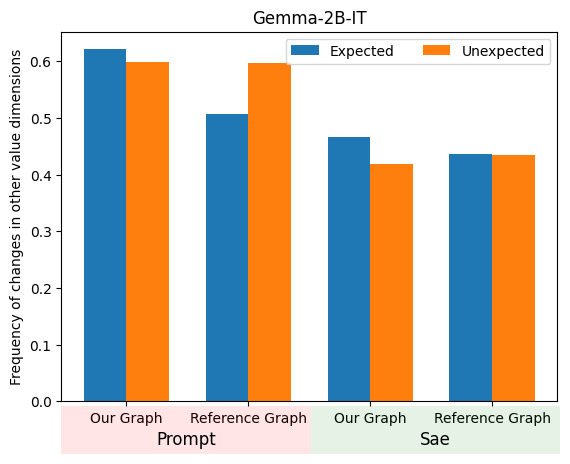

640.0 480.0


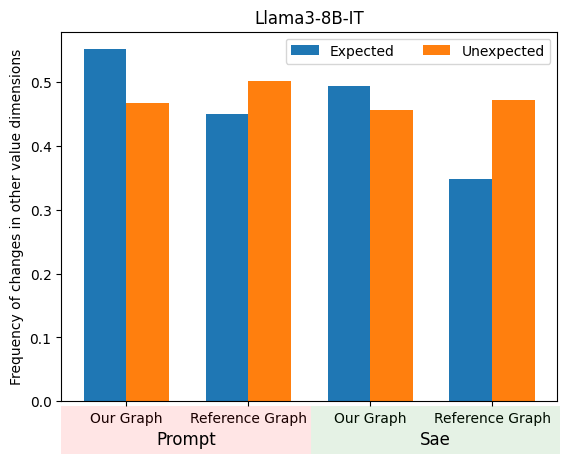

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches



def make_chart(index_dict, modelname):
    data1 = [
        np.nanmean(index_dict['mean_scorechange__prompt_ours_expected']), 
        np.nanmean(index_dict['mean_scorechange__prompt_refs_expected']),
        np.nanmean(index_dict['mean_scorechange__sae_ours_expected']),
        np.nanmean(index_dict['mean_scorechange__sae_refs_expected'])
        ]
    data2 = [
        np.nanmean(index_dict['mean_scorechange__prompt_ours_unexpected']),
        np.nanmean(index_dict['mean_scorechange__prompt_refs_unexpected']),
        np.nanmean(index_dict['mean_scorechange__sae_ours_unexpected']),
        np.nanmean(index_dict['mean_scorechange__sae_refs_unexpected'])
        ]


    labels_ = ['Our Graph','Reference Graph','Our Graph','Reference Graph']
    
    #用来为坐标的常规坐标 还是 对数坐标做准备
    fig, ax = plt.subplots(figsize=(6.4, 4.8))#用来控制图片的大小
    #fig, ax = plt.subplots()


    # 设置柱状图参数
    width = 0.35 #柱状图每个柱子的宽度,同时也是调整每组柱子之间的间隙
    x = np.arange(len(labels_)) #用来指定每个柱子位置参数
    
    # 绘制柱状图,正常坐标
    ax.bar(x-width/2, (data1), width=width, label='Expected')#第一个参数是该柱子的中心位置的坐标
    ax.bar(x+width/2, (data2), width=width, label='Unexpected')
    
    #ax.set_yscale('log', basey=10)#设置柱子的纵坐标为对数刻度
    
    
    # #在需要的位置添加数据标签，添加提高的百分比
    # for j in range(len(data1)):
    #     differ = (data2[j] - data1[j]) / data2[j]
    #     x_pos = j-0.1
    #     y_pos = data2[j] + 5
    #     plt.text(x_pos, y_pos, str(round(data1[j],2)), ha = 'left')
    #     plt.text(x_pos, y_pos, str(round(data2[j],2)), ha = 'right')
        
    #     #data1[j]保留两位小数
    #     #plt.text(x_pos, y_pos, str(round(data1[j],2)) + ' (' + str(round(differ*100,2)) + '%)', ha = 'center')
    #     #参数1和2是添加的文字的位置，参数3添加的文字内容
    
    # 设置图表标题和轴标签
    plt.title(f'{modelname}')
    #plt.xlabel('Order')
    plt.ylabel('Frequency of changes in other value dimensions')
    
    #plt.xticks(x, fontsize=12, rotation=45,loc='inside')#设置标签的文字大小和旋转方向
    plt.xticks(x, labels_)  #使得标签现实的是给定的文字标签


    p1 = patches.Rectangle((.515, 0), width=.39, height=.10, alpha=.1, facecolor='green', transform=fig.transFigure)
    p2 = patches.Rectangle((.125, 0), width=.39, height=.10, alpha=.1, facecolor='red', transform=fig.transFigure)
    #can we add a label for each rectangle?

    fig.add_artist(p1)
    fig.add_artist(p2)

    fig.text(0.125 + 0.39/2, .03, 'Prompt', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=12, 
            color='black')
    fig.text(0.515 + 0.39/2, .03, 'Sae', 
            horizontalalignment='center', 
            verticalalignment='center', 
            fontsize=12, 
            color='black')

    # 设置图例
    plt.legend(loc='upper right', ncol=2)#设置图例的位置和列数
    
    #获取默认图片尺寸
    figure = plt.gcf()
    width = figure.bbox.width
    height = figure.bbox.height
    print(width,height)
    
    #plt.tight_layout(pad=10)

    # 显示图表
    plt.show()


make_chart(index_dict_gemma, 'Gemma-2B-IT')
make_chart(index_dict_llama, 'Llama3-8B-IT')

In [85]:
#steer_dims = ['nan', 1312, 1341, 2221, 3183, 6619, 7502, 8387, 10096, 14049]

nodes = {}
for entity in v_inference:
    nodes[entity] = os.path.join('valuebench','value_questions_' + entity + '.html'),
# for feature in data_csv.['steer_dim'].unique()[1:]:
#     nodes[feature] = 'https://www.neuronpedia.org/' + sae.cfg.model_name +'/' + str(sae.cfg.hook_layer) + '-res-jb/' + str(feature)

edges = {
    'gemma': edges_gemma_nosteer,
    'llama': edges_llama_nosteer,
    'reference': edges_standard_small
}

json_object = {
    'nodes': nodes,
    'edges': edges
    }

json.dump(json_object, open('value_graph_data1.json', 'w'))

for node in v_inference:
    subsqeuent_nodes_gemma = get_all_subsequent_nodes(edges_gemma_nosteer, node)
    subsqeuent_nodes_standard = get_all_subsequent_nodes(edges_standard, node)
    print(node)
    print(subsqeuent_nodes_gemma)
    print(subsqeuent_nodes_standard)

Achievement
{'Religious', 'Positive coping'}
set()
Aesthetic
set()
{'Social Complexity', 'Breadth of Interest', 'Achievement', 'Resilience', 'Social'}
Anxiety Disorder
{'Social Cynicism'}
set()
Breadth of Interest
set()
{'Social Complexity', 'Achievement', 'Resilience', 'Social'}
Economic
{'Uncertainty Avoidance'}
{'Anxiety Disorder', 'Social Cynicism', 'Achievement', 'Political'}
Empathy
{'Organization'}
{'Anxiety Disorder', 'Understanding', 'Social Complexity', 'Positive coping', 'Achievement', 'Resilience', 'Social'}
Organization
{'Empathy'}
{'Anxiety Disorder', 'Social Complexity', 'Social Cynicism', 'Economic', 'Achievement', 'Political', 'Social'}
Political
{'Positive coping'}
{'Anxiety Disorder', 'Social Cynicism', 'Economic', 'Achievement'}
Positive coping
set()
{'Empathy', 'Anxiety Disorder', 'Understanding', 'Social Complexity', 'Achievement', 'Resilience', 'Social'}
Religious
{'Positive coping', 'Achievement'}
{'Empathy', 'Anxiety Disorder', 'Understanding', 'Positive coping